In [1]:
import pandas as pd
import numpy as np
import rebound
import reboundx
import matplotlib.pyplot as plt
from multiprocessing import Pool
from matplotlib.lines import Line2D


In [2]:

# Constantes de conversión
M_Sun = 1.98847e30  # Masa del Sol en kg
M_Jup = 1.89813e27  # Masa de Júpiter en kg
R_Jup = 7.1492e7  # Radio de Júpiter en metros
AU_in_m = 1.495978707e11  # Unidades Astronómicas en metros
R_Io_km = 1821.6  # Radio de Io en km
R_Io_m = R_Io_km * 1000  # Radio de Io en metros
M_Io_kg = 8.9319e22  # Masa de Io en kg

# Cargar el archivo con los parámetros relevantes
file_path = './data_wasp49Ab.csv'  # Ruta del archivo proporcionado
wasp49_data = pd.read_csv(file_path)

# Extraer los parámetros relevantes del archivo proporcionado
mass_planet = wasp49_data['mass'].iloc[0]  # Masa del planeta en M_Jup
radius_planet = wasp49_data['radius'].iloc[0]  # Radio del planeta en R_Jup
a_planet = wasp49_data['semi_major_axis'].iloc[0]  # Semieje mayor en AU
e_planet      = 0.03#wasp49_data['eccentricity'].iloc[0]  # Excentricidad
mass_star = wasp49_data['star_mass'].iloc[0]  # Masa de la estrella en M_Sun

###########################################################
# Constantes físicas#
n_mass = 1 # Masa de la luna en múltiplos de Io
mass_moon_kg = n_mass * M_Io_kg  # Masa de la luna en kg

############################################################
# Relación masa-radio para lunas rocosas (exponente ajustado)
def calcular_radio_moon(mass_moon_kg):
    return R_Io_m * (mass_moon_kg / M_Io_kg) ** (1/3.5)  # Ajustar el exponente para mejorar la precisión

# Calcular el radio de la luna
radius_moon_m = calcular_radio_moon(mass_moon_kg)

# Convertir masas a M_Sun
mass_planet_sun = mass_planet * 0.000954588  # Masa del planeta en M_Sun
mass_star_sun = mass_star  # Masa de la estrella en M_Sun
mass_moon_sun = mass_moon_kg / M_Sun  # Masa de la luna en M_Sun

# Convertir radios a AU
radius_planet_au = radius_planet * R_Jup / AU_in_m  # Radio del planeta en AU
radius_moon_au = radius_moon_m / AU_in_m  # Radio de la luna en AU

# Funciones para calcular parámetros relevantes
def calcular_limite_roche(mass_planet, mass_moon, radius_moon):
    """
    Calcula el límite de Roche para una luna orbitando un planeta,
    considerando las masas y el radio de la luna.
    """
    limite_roche = 2.44 * (mass_planet / mass_moon) ** (1/3) * radius_moon
    return limite_roche

def calcular_radio_hill(mass_planet, mass_star, a_planet):
    """
    Calcula el radio de Hill para un planeta orbitando una estrella.
    """
    radio_hill = a_planet * (mass_planet / (3 * mass_star)) ** (1/3)
    return radio_hill

# Calcular límite de Roche y radio de Hill
limite_roche = calcular_limite_roche(mass_planet_sun, mass_moon_sun, radius_moon_au)
radio_hill = calcular_radio_hill(mass_planet_sun, mass_star_sun, a_planet)

# Imprimir resultados
print(f"Radio de la luna (m): {radius_moon_m}")
print(f"Radio de la luna (r_Io): {radius_moon_m/(1000*R_Io_km)}")
print(f"Masa de la luna (m_Io): {mass_moon_kg/M_Io_kg}")
print(f"Límite de Roche (AU): {limite_roche/radius_planet_au}")
print(f"Radio de Hill (AU): {radio_hill/radius_planet_au}")

# Configuración inicial y cálculo de J2
P_rot_s = 2.8 * 24 * 60 * 60  # Período de rotación en segundos
mass_planet_kg = mass_planet * M_Jup  # Masa del planeta en kg
radius_planet_m = radius_planet * R_Jup  # Radio del planeta en metros

# Calcular J2
def calcular_J2(mass_planet_kg, radius_planet_m, P_rot_s):
    Omega = 2 * np.pi / P_rot_s  # Velocidad angular en rad/s
    G = 6.67430e-11  # Constante gravitacional en m^3 kg^-1 s^-2
    J2 = (1/2) * (3/2) * ((Omega**2) * (radius_planet_m**3)) / (G * mass_planet_kg)
    return J2

J2_value = calcular_J2(mass_planet_kg, radius_planet_m, P_rot_s)
print(f"El valor de J2 para el planeta es: {J2_value}")

# Crear la lista de parámetros para todas las combinaciones de a y e
#####################################################################
Ngrid = 40
t_end = 1e3
dt    = 1e-5
par_a = np.linspace(1 * limite_roche, 0.5 * radio_hill, Ngrid)
par_e = np.linspace(0., 0.5, Ngrid)
par_i_values = np.deg2rad([0, 10, 20, 30, 39])  # Inclinaciones en radianes
parameters = [(a, e) for e in par_e for a in par_a]
#####################################################################

# Función para calcular si una luna es expulsada con efectos de J2 y GR
def simulation_ejection_with_J2_GR(par):
    """
    Ejecuta una simulación de Rebound y verifica si la luna es expulsada del sistema,
    teniendo en cuenta el efecto J2 del planeta y las correcciones relativistas.

    Parameters:
    - par (tuple): Tupla que contiene (a_moon, e_moon)

    Returns:
    - int: 0 si la luna es expulsada, 1 si la luna permanece en órbita
    """
    a, e = par
    sim = rebound.Simulation()
    sim.units = ('AU', 'yr', 'Msun')
    sim.integrator = "whfast"
    sim.dt = dt

    # Añadir la estrella
    sim.add(m=mass_star_sun, hash="star")  # Estrella central

    # Añadir el planeta orbitando la estrella
    sim.add(m=mass_planet_sun, a=a_planet, e=e_planet, r=radius_planet_au, hash="planet")

    # Añadir la luna orbitando el planeta
    sim.add(m=mass_moon_sun, a=a, e=e, inc=par_i, primary=sim.particles[1], hash="moon")

    # Adding relativistic effects y J2 usando REBOUNDx
    rebx = reboundx.Extras(sim)
    gr = rebx.load_force("gr_potential")
    rebx.add_force(gr)
    gr.params["c"] = 63241.077  # Velocidad de la luz en AU/yr

    # Adding planet oblateness (J2)
    gh = rebx.load_force("gravitational_harmonics")
    rebx.add_force(gh)
    planet = sim.particles["planet"]
    planet.params["J2"] = J2_value
    planet.params["R_eq"] = radius_planet_au

    sim.move_to_com()

    try:
        while sim.t < t_end * 2 * np.pi:
            sim.integrate(sim.t + 1e-2, exact_finish_time=0)
            # Verificar si la excentricidad de la luna supera 1 (es expulsada) o si el periapsis es menor que el radio del planeta
            moon_orbit = sim.particles["moon"].orbit(primary=sim.particles["planet"])
            periapsis = moon_orbit.a * (1 - moon_orbit.e)  # Cálculo del periapsis
            if moon_orbit.e >= 1.0 or moon_orbit.a < limite_roche or moon_orbit.a > radio_hill or periapsis <= radius_planet_au:
                return 0  # La luna es expulsada
        return 1  # La luna permanece en órbita
    except rebound.Escape:
        return 0  # La luna es expulsada

# Inicializar la matriz que contendrá la suma de todos los resultados
ejection_matrix_sum = np.zeros((len(par_e), len(par_a)), dtype=int)

# Ejecutar las simulaciones en paralelo para cada inclinación
for idx, par_i in enumerate(par_i_values):
    # Actualizar los parámetros con el valor actual de inclinación
    params_with_inclination = [(a, e) for (a, e) in parameters]

    ejection_results = []
    with Pool() as pool:
        ejection_results = pool.map(simulation_ejection_with_J2_GR, params_with_inclination)

    # Convertir los resultados en una matriz
    ejection_matrix = np.array(ejection_results, dtype=int).reshape((len(par_e), len(par_a)))

    # Acumular los resultados en la matriz de suma
    ejection_matrix_sum += ejection_matrix
    print(np.rad2deg(par_i),'°')
    print(ejection_matrix)

    # Definir la ruta y nombre del archivo para guardar los datos, incluyendo la inclinación
    save_path = f'./data/ejection_J2_GR_map_a_e_t{t_end:.0f}_i{np.rad2deg(par_i):.0f}_Ms{n_mass}.npz'

    # Guardar par_a, par_e y ejection_matrix en un archivo comprimido .npz
    np.savez_compressed(save_path, par_a=par_a, par_e=par_e, ejection_matrix=ejection_matrix)

    print(f'Datos guardados exitosamente en {save_path}')

# Guardar la matriz completa de resultados acumulados
full_save_path = './data/ejection_J2_GR_sum_results.npz'
np.savez_compressed(full_save_path, par_a=par_a, par_e=par_e, ejection_matrix_sum=ejection_matrix_sum)
print(f'Matriz completa de resultados acumulados guardada exitosamente en {full_save_path}')

# Visualizar los resultados de expulsión
A, E = np.meshgrid(par_a, par_e)


Radio de la luna (m): 1821600.0
Radio de la luna (r_Io): 1.0
Masa de la luna (m_Io): 1.0
Límite de Roche (AU): 1.0582377868649417
Radio de Hill (AU): 3.412576671604123
El valor de J2 para el planeta es: 0.006288045478463178
0.0 °
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Datos guardados exitosamente en ./data/ejection_J2_GR_map_a_e_t1000_i0_Ms1.npz
10.0 °
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Datos guardados exitosamente en ./data/ejection_J2_GR_map_a_e_t1000_i10_Ms1.npz
20.0 °
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Datos guardados exitosamente en ./data/ejection_J2_GR_map_a_e_t1000_i20_Ms1.npz
29.999999999999996 °
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Datos guardados 

Gráfico guardado exitosamente como figures/ejection_map_J2_GR_potential_a_e_i_full_t1000.0_Ms1_N40.png


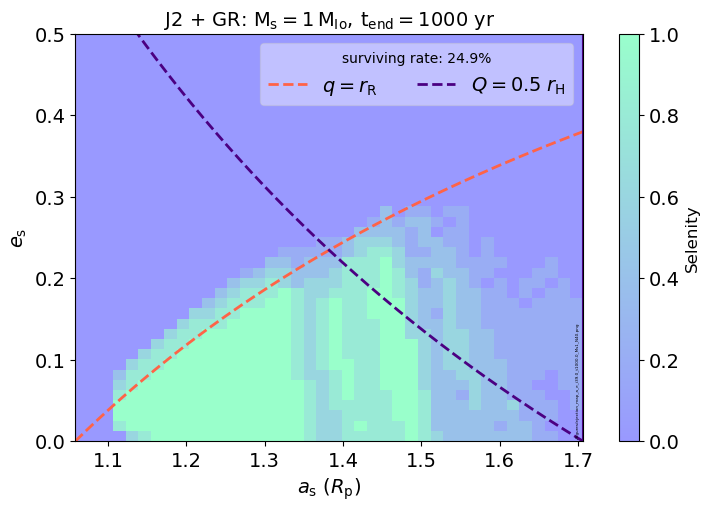

In [5]:

# Crear el gráfico de expulsión vs a/Rp y e
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = plt.subplot(111)

# Definir el extent del gráfico en términos de a/Rp y e
extent = [min(par_a/radius_planet_au), max(par_a/radius_planet_au), min(par_e), max(par_e)]
ax.set_xlim(extent[0], extent[1])
ax.set_xlabel(r"$a_\mathrm{s}$ ($R_\mathrm{p}$)", fontsize=14)
ax.set_ylim(extent[2], extent[3])
ax.set_ylabel(r"$e_\mathrm{s}$", fontsize=14)

# Aumentar el tamaño de los ticks en los ejes X e Y
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Calcular la curva a/Rp = limite_roche_Rp / (1 - e) para Periapsis
e_curve_peri = np.linspace(min(par_e), max(par_e), 500)
a_curve_peri = (limite_roche / radius_planet_au) / (1 - e_curve_peri)

# Dibujar la curva q = limite_roche
ax.plot(a_curve_peri, e_curve_peri, color='tomato', linestyle='--', linewidth=2,
        label=r'$q = \text{Límite de Roche}$')

# Calcular la curva a/Rp = radio_hill_Rp / (1 + e) para Apoapsis
e_curve_apo = np.linspace(min(par_e), max(par_e), 500)
a_curve_apo = (0.5 * radio_hill / radius_planet_au) / (1 + e_curve_apo)

# Dibujar la curva Q = radio_hill
ax.plot(a_curve_apo, e_curve_apo, color='indigo', linestyle='--', linewidth=2,
        label=r'$Q = \text{Radio de Hill}$')

# Graficar la imagen de expulsión
im = ax.imshow(ejection_matrix_sum/len(par_i_values), interpolation="none", cmap="winter",
               origin="lower", aspect='auto', extent=extent, alpha=0.4)
cb = plt.colorbar(im, ax=ax)
cb.set_label("Selenity", fontsize=12)
cb.ax.tick_params(labelsize=14)

# Configurar el título con LaTeX
ax.set_title(fr'J2 + GR: M$_{{\mathrm{{s}}}} = {n_mass} \, \mathrm{{M}}_{{\mathrm{{Io}}}}, \, \mathrm{{t}}_{{\mathrm{{end}}}} = {t_end:g}$ yr', fontsize=14)

# Dibujar líneas verticales para el límite de Roche y el radio de Hill
ax.vlines(limite_roche / radius_planet_au, min(par_e), max(par_e),
          linestyles='solid', color='tomato')
ax.vlines(0.5 * radio_hill / radius_planet_au, min(par_e), max(par_e),
          linestyles='solid', color='indigo')

# Añadir la leyenda al gráfico
legend_elements = [
    Line2D([0], [0], color='tomato', linestyle='dashed', lw=2, label=r'$q = {{r}}_\mathrm{{R}} $'),
    Line2D([0], [0], color='indigo', linestyle='dashed', lw=2, label=r'$Q = 0.5 \; {{r}}_\mathrm{{H}} $'),
]
ax.legend(handles=legend_elements, ncols=2, title=f'surviving rate: {(ejection_matrix_sum.sum() / (len(par_i_values)* len(ejection_matrix_sum)**2)) * 100:.1f}%', loc='upper right', fontsize=14, framealpha=0.4)
ax.text(0.99,0.15,f'./figures/ejection_map_a_e_i{np.round(np.rad2deg(par_i))}_t{t_end}_Ms{n_mass}_N{Ngrid}.png', fontsize=3, rotation =90, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Guardar el gráfico
plt.savefig(f'./figures/plooneticity_J2_GR_potential_a_e_i_full_t{t_end}_Ms{n_mass}_N{Ngrid}.png', facecolor='w', dpi=300)
print(f'Gráfico guardado exitosamente como figures/ejection_map_J2_GR_potential_a_e_i_full_t{t_end}_Ms{n_mass}_N{Ngrid}.png')

In [4]:
ejection_matrix_sum

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
ejection_matrix_sum.sum()

115